In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import folium
import altair as alt

import researchpy as rp
from scipy.stats import f_oneway
import statsmodels.stats.multicomp as mc
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import ttest_rel

from sklearn.decomposition import PCA
from math import pi

## Data preprocessing

In [2]:
develop2015 = pd.read_csv("Develop2015_2.csv")
develop2015.replace('..','NaN',inplace=True)
develop2015 = develop2015[:-5]
develop2015.columns

Index(['Country Name', 'Country Code', 'Time', 'Time Code',
       'Mortality rate, infant (per 1,000 live births) [SP.DYN.IMRT.IN]',
       'Energy use (kg of oil equivalent per capita) [EG.USE.PCAP.KG.OE]',
       'CO2 emissions (kt) [EN.ATM.CO2E.KT]',
       'GDP (constant 2015 US$) [NY.GDP.MKTP.KD]',
       'GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]',
       'Forest area (sq. km) [AG.LND.FRST.K2]',
       'Voice and Accountability: Percentile Rank [VA.PER.RNK]'],
      dtype='object')

In [3]:
develop_var = develop2015[['Country Name', 'Country Code',
                           'Mortality rate, infant (per 1,000 live births) [SP.DYN.IMRT.IN]',
                           'CO2 emissions (kt) [EN.ATM.CO2E.KT]',
                           'GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]',
                           'Forest area (sq. km) [AG.LND.FRST.K2]',
                           'Voice and Accountability: Percentile Rank [VA.PER.RNK]']]

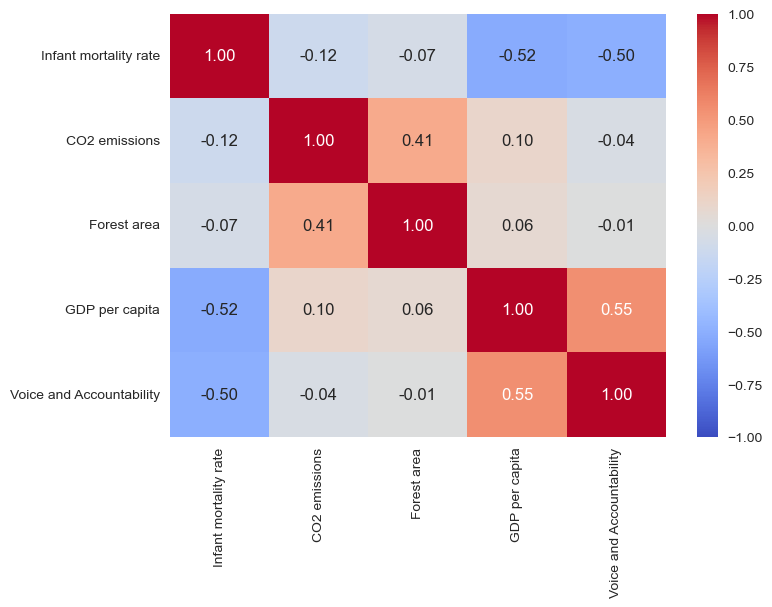

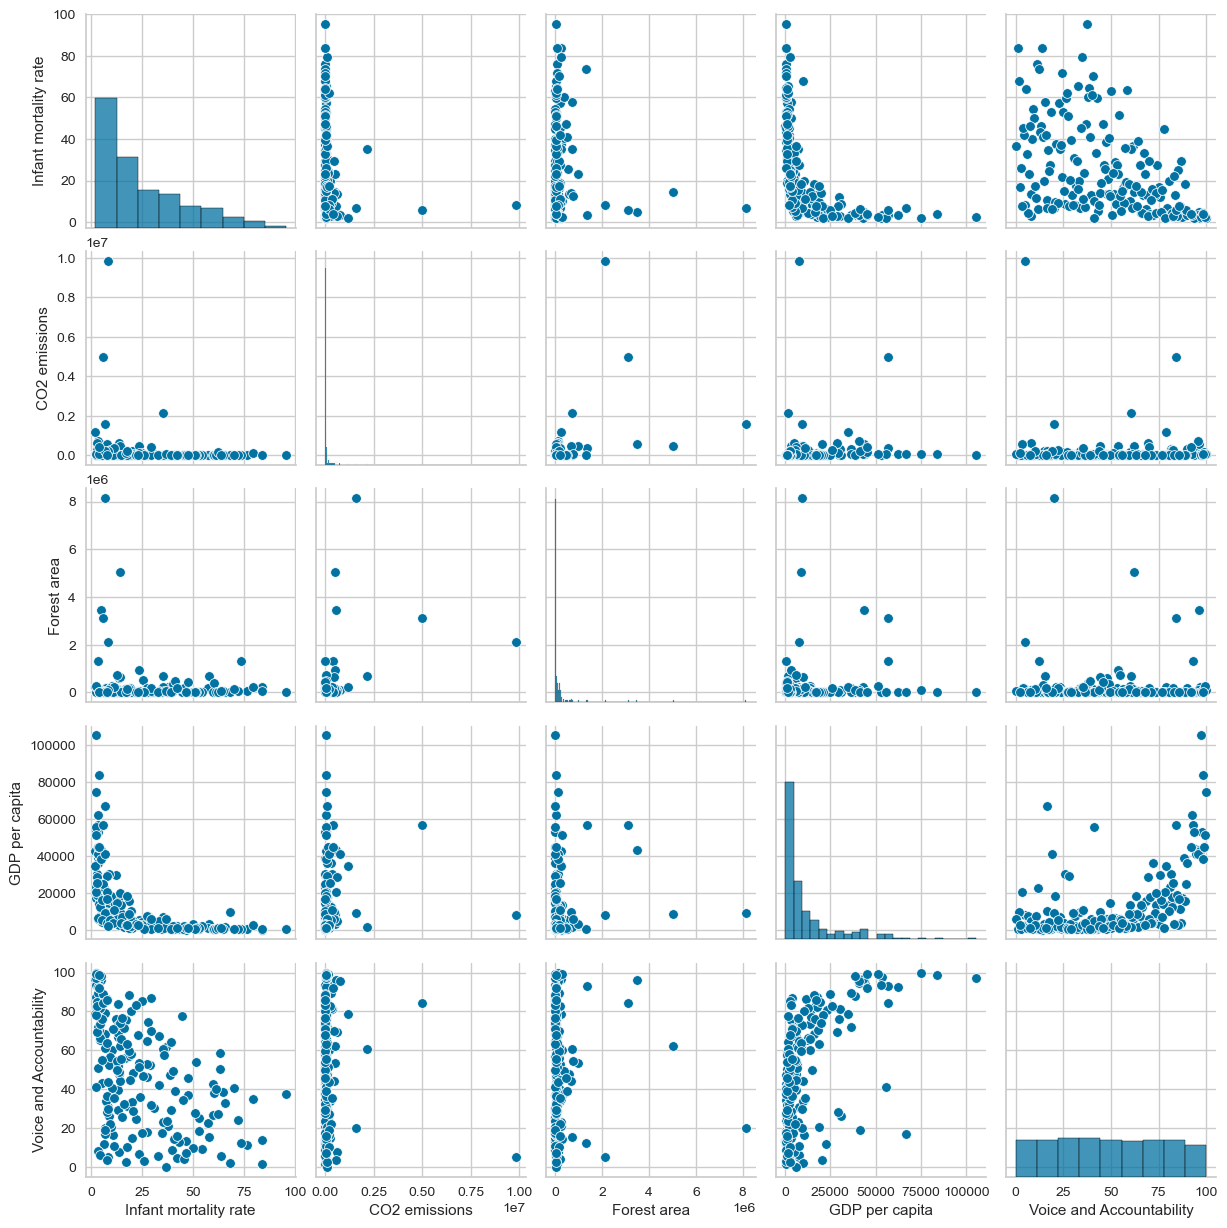

In [4]:
develop_var = develop_var.rename(columns={'Mortality rate, infant (per 1,000 live births) [SP.DYN.IMRT.IN]':'Infant mortality rate',
                                          'CO2 emissions (kt) [EN.ATM.CO2E.KT]':'CO2 emissions',
                                          'Forest area (sq. km) [AG.LND.FRST.K2]':'Forest area',
                                          'GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]':'GDP per capita',
                                          'Voice and Accountability: Percentile Rank [VA.PER.RNK]':'Voice and Accountability'})

col = ['Infant mortality rate','CO2 emissions','Forest area','GDP per capita','Voice and Accountability']

develop_var[col] = develop_var[col].astype(float)
develop_clean = develop_var.dropna()
develop_clean = develop_clean.reset_index(drop=True)

corr_matrix = develop_clean[col].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',fmt='.2f',vmin=-1, vmax=1)
plt.show()

sns.pairplot(develop_clean[col])
plt.show()

## Clustering Methods

**Standardise all variable**

In [5]:
logcol = ['Infant mortality rate','CO2 emissions','Forest area','GDP per capita']
scacol = ['Infant mortality rate','CO2 emissions','Forest area','GDP per capita','Voice and Accountability']

scaler = StandardScaler()

develop_var = develop_clean.copy()
develop_var[logcol] = np.log1p(develop_var[logcol])
scaled_data = scaler.fit_transform(develop_var[scacol])
scaled_df = pd.DataFrame(scaled_data,columns=scacol)

cluster_results = {} #to store the results

### Clustering Analysis

In this section, we apply three different clustering methods to group countries based on their development indicators and compare the results.  

**Methods**:  
- K-Means  
- Hierarchical (Agglomerative)  
- Gaussian Mixture Model (GMM)  

**Evaluation Metrics**:  
- Silhouette Score  
- Calinski-Harabasz Index  
- Davies-Bouldin Index

In [6]:
# k-means
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=147, n_init='auto')
    labels = kmeans.fit_predict(scaled_data)
    cluster_results[f'KMeans_{k}'] = labels

In [7]:
# Hierarchical
for k in range(2, 9):
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(scaled_data)
    cluster_results[f'Agglomerative_{k}'] = labels

In [8]:
# Gaussian Mixture Model (GMM)
for k in range(2, 9):
    gmm = GaussianMixture(n_components=k, random_state=147)
    labels = gmm.fit_predict(scaled_data)
    cluster_results[f'GMM_{k}'] = labels

In [9]:
# evaluation metrics calculation
metrics_list = []
for key, labels in cluster_results.items():
    sil = silhouette_score(scaled_data, labels)
    ch = calinski_harabasz_score(scaled_data, labels)
    db = davies_bouldin_score(scaled_data, labels)
    metrics_list.append({
        "Method": key.split("_")[0],
        "k": int(key.split("_")[1]),
        "Silhouette": sil,
        "Calinski-Harabasz": ch,
        "Davies-Bouldin": db
    })

metrics_df = pd.DataFrame(metrics_list)

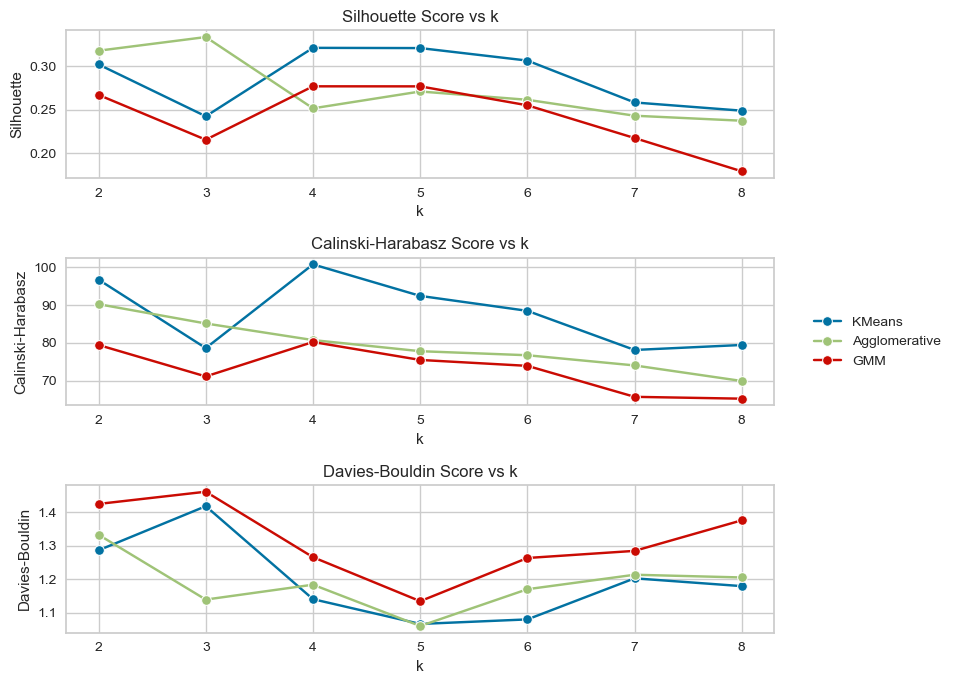

In [10]:
# Plot metrics comparison
fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=False)

# Silhouette score
sns.lineplot(data=metrics_df, x="k", y="Silhouette", hue="Method", marker="o", ax=axes[0])
axes[0].set_title("Silhouette Score vs k")
axes[0].legend_.remove()

# Calinski-Harabasz Score
sns.lineplot(data=metrics_df, x="k", y="Calinski-Harabasz", hue="Method", marker="o", ax=axes[1])
axes[1].set_title("Calinski-Harabasz Score vs k")
axes[1].legend_.remove()

# Davies-Bouldin Score
sns.lineplot(data=metrics_df, x="k", y="Davies-Bouldin", hue="Method", marker="o", ax=axes[2])
axes[2].set_title("Davies-Bouldin Score vs k")
axes[2].legend_.remove()

# share legendon the right side
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)

plt.tight_layout()
plt.show()

***Results***

- **K-Means**: 4 clusters achieve the best metric scores; 5 clusters are close and more interpretable (see original report).  
- **GMM**: Slightly lower metrics than K-Means, but similar cluster patterns.  
- **Agglomerative**: Less stable across different cluster numbers.

### Deep Dive into Comparison (5 Clusters)

Here we compare the cluster characteristics of **K-Means** and **GMM** when grouping countries into 5 clusters.  

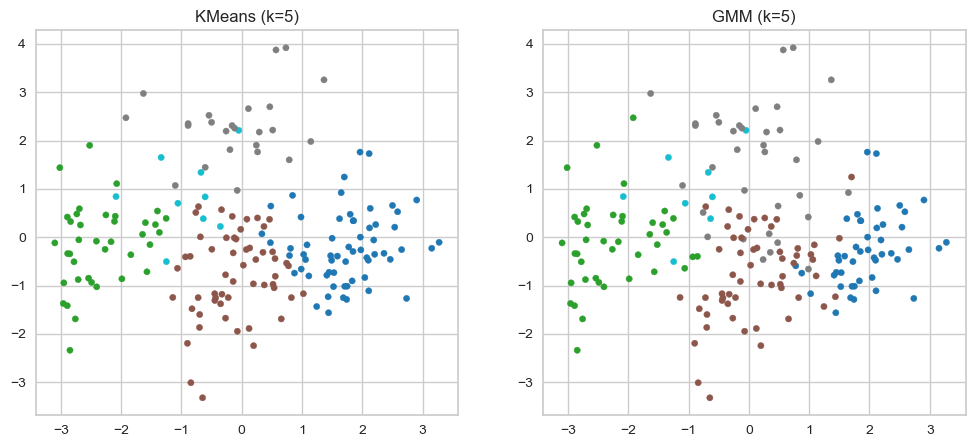

In [11]:
# use PCA to demintional into 2 
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_df)

# KMeans & GMM clustering into 5
kmeans_labels = cluster_results["KMeans_5"]
gmm_labels = cluster_results["GMM_5"]

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(reduced[:, 0], reduced[:, 1], c=kmeans_labels, cmap="tab10", s=20)
axes[0].set_title("KMeans (k=5)")

axes[1].scatter(reduced[:, 0], reduced[:, 1], c=gmm_labels, cmap="tab10", s=20)
axes[1].set_title("GMM (k=5)")

plt.show()

In [15]:
pd.crosstab(cluster_results["KMeans_5"], cluster_results["GMM_5"])

col_0,0,1,2,3,4
row_0,,,,,
0,44,0,10,7,0
1,0,38,0,0,0
2,2,3,45,5,0
3,0,1,0,23,0
4,0,0,1,0,8


In [12]:
# create the clustering datasets
cols = ['Infant mortality rate','CO2 emissions','Forest area','GDP per capita','Voice and Accountability']

develop_km = develop_var[cols].copy()
develop_km['Cluster'] = cluster_results['KMeans_5']
develop_km['Method'] = 'KMeans'

develop_gmm = develop_var[cols].copy()
develop_gmm['Cluster'] = cluster_results['GMM_5']
develop_gmm['Method'] = 'GMM'

combined_df = pd.concat([develop_km, develop_gmm], axis=0) #combine the datasets

In [13]:
def wcss_bcss(df, cluster_col, numeric_cols):
    overall_mean = df[numeric_cols].mean().values
    wcss = 0
    bcss = 0
    for c in df[cluster_col].unique():
        cluster_data = df[df[cluster_col]==c][numeric_cols].values
        cluster_mean = cluster_data.mean(axis=0)
        wcss += ((cluster_data - cluster_mean)**2).sum()
        bcss += len(cluster_data) * ((cluster_mean - overall_mean)**2).sum()
    return wcss, bcss

features = ['Infant mortality rate','CO2 emissions','Forest area','GDP per capita','Voice and Accountability']
for method in ['KMeans','GMM']:
    df_method = combined_df[combined_df['Method']==method]
    wcss, bcss = wcss_bcss(df_method, 'Cluster', features)
    print(f"{method}: WCSS={wcss:.2f}, BCSS={bcss:.2f}")


KMeans: WCSS=49621.11, BCSS=106439.25
GMM: WCSS=40684.56, BCSS=115375.80


In [14]:
for method in ['KMeans','GMM']:
    df_method = combined_df[combined_df['Method']==method]
    score = silhouette_score(df_method[features], df_method['Cluster'])
    print(f"{method}: Silhouette Score={score:.3f}")


KMeans: Silhouette Score=-0.034
GMM: Silhouette Score=0.019


In [16]:
# calculate the mean and std in every group
summary = combined_df.groupby(['Method','Cluster']).agg(['mean','std'])
summary

Infant mortality rate           CO2 emissions            \
                                mean       std          mean       std   
Method Cluster                                                           
GMM    0                    3.907803  0.317451      8.180899  1.398663   
       1                    1.532128  0.301712     10.948802  1.793459   
       2                    2.808404  0.650044     10.915477  1.831732   
       3                    3.003752  0.456004      6.416189  1.716439   
       4                    2.033297  0.376240     10.388038  1.633442   
KMeans 0                    3.835439  0.381121      8.244523  1.477385   
       1                    1.494777  0.279360     11.080900  1.708174   
       2                    2.658074  0.521763     10.954094  1.794725   
       3                    2.806026  0.515097      5.638953  1.307386   
       4                    2.052739  0.356741     10.367617  1.529173   

               Forest area           GDP per capita            \
                      mean       std           mean       std   
Method Cluster                                                  
GMM    0         10.478747  2.056679       7.024241  0.807253   
       1         10.411202  2.077290      10.220220  0.696981   
       2         10.727855  2.146829       8.305084  0.690588   
       3          7.169547  3.305306       8.724974  0.846191   
       4          4.145771  2.910708      10.290294  0.627079   
KMeans 0         10.476650  1.951486       7.127819  0.748744   
       1         10.533743  1.995594      10.318015  0.611020   
       2         10.865847  2.050069       8.601930  0.537017   
       3          5.281673  2.180214       8.911377  0.929228   
       4          4.490385  2.912390      10.142745  0.734853   

               Voice and Accountability             
                                   mean        std  
Method Cluster                                      
GMM    0                      20.871707  13.660856  
       1                      84.283369  11.893939  
       2                      37.543983  18.457336  
       3                      68.177340  12.647616  
       4                      24.261084   9.211202  
KMeans 0                      28.878301  17.496393  
       1                      86.103190  10.191957  
       2                      38.575907  20.711119  
       3                      75.102627   9.870383  
       4                      25.013684   8.907195

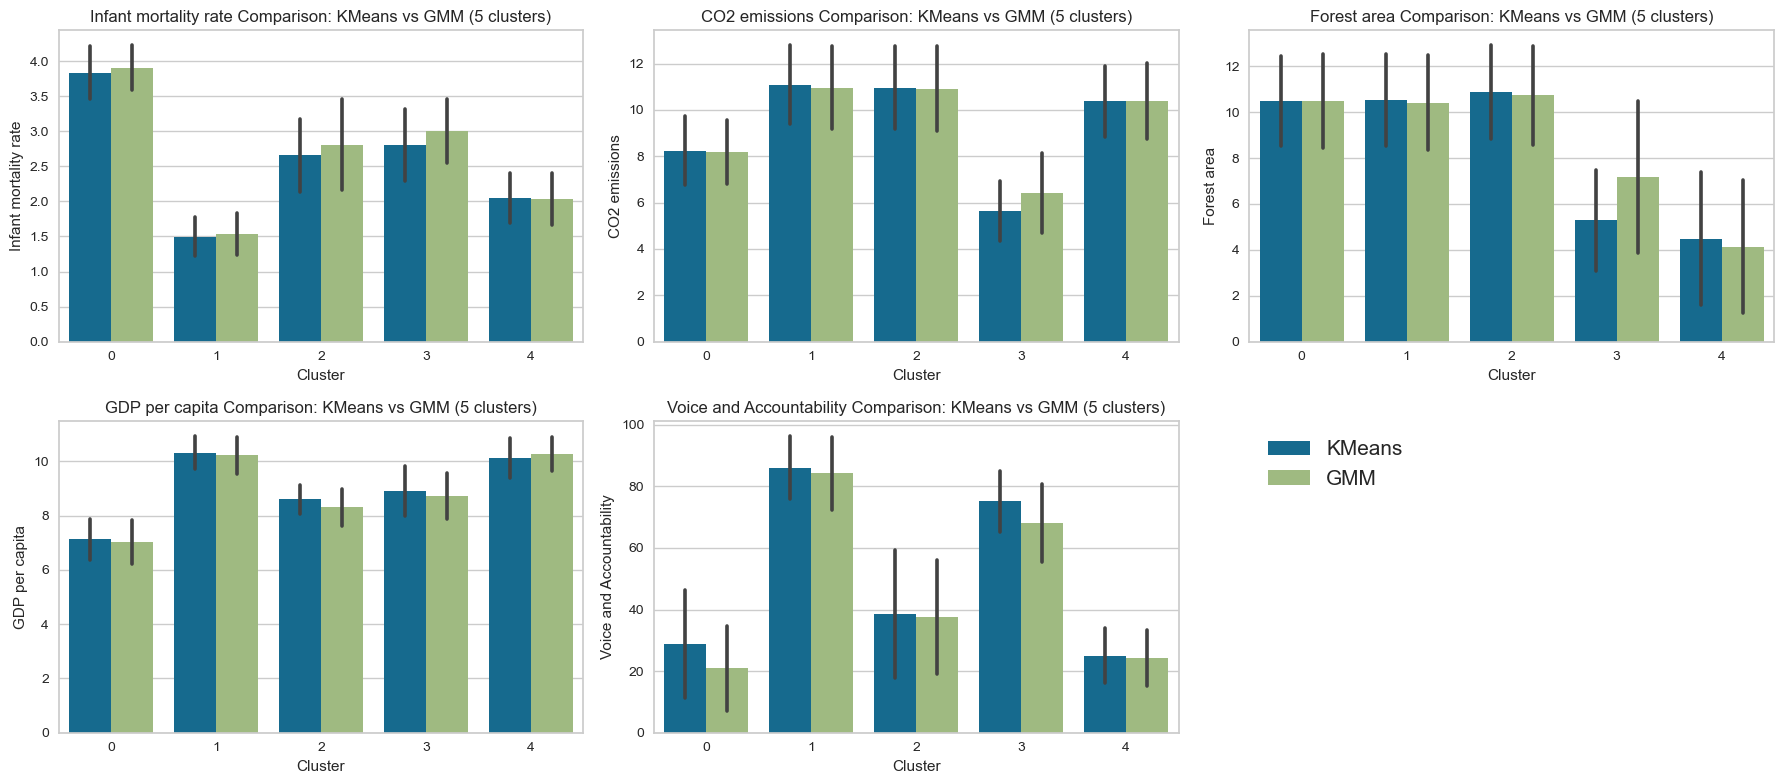

In [17]:
# List of indicators
features = ['Infant mortality rate','CO2 emissions','Forest area','GDP per capita','Voice and Accountability']

# Create 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    sns.barplot(data=combined_df, x='Cluster', y=feature, hue='Method',
                errorbar='sd', ax=axes[i])
    axes[i].set_title('%s Comparison: KMeans vs GMM (5 clusters)' % feature)
    axes[i].get_legend().remove()  # Remove individual legends

# Use the last (6th) subplot for a common legend
handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from first subplot
axes[-1].axis('off')  # Hide axes
axes[-1].legend(handles, labels, loc='upper left', fontsize=15, frameon=False)  # Add title

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

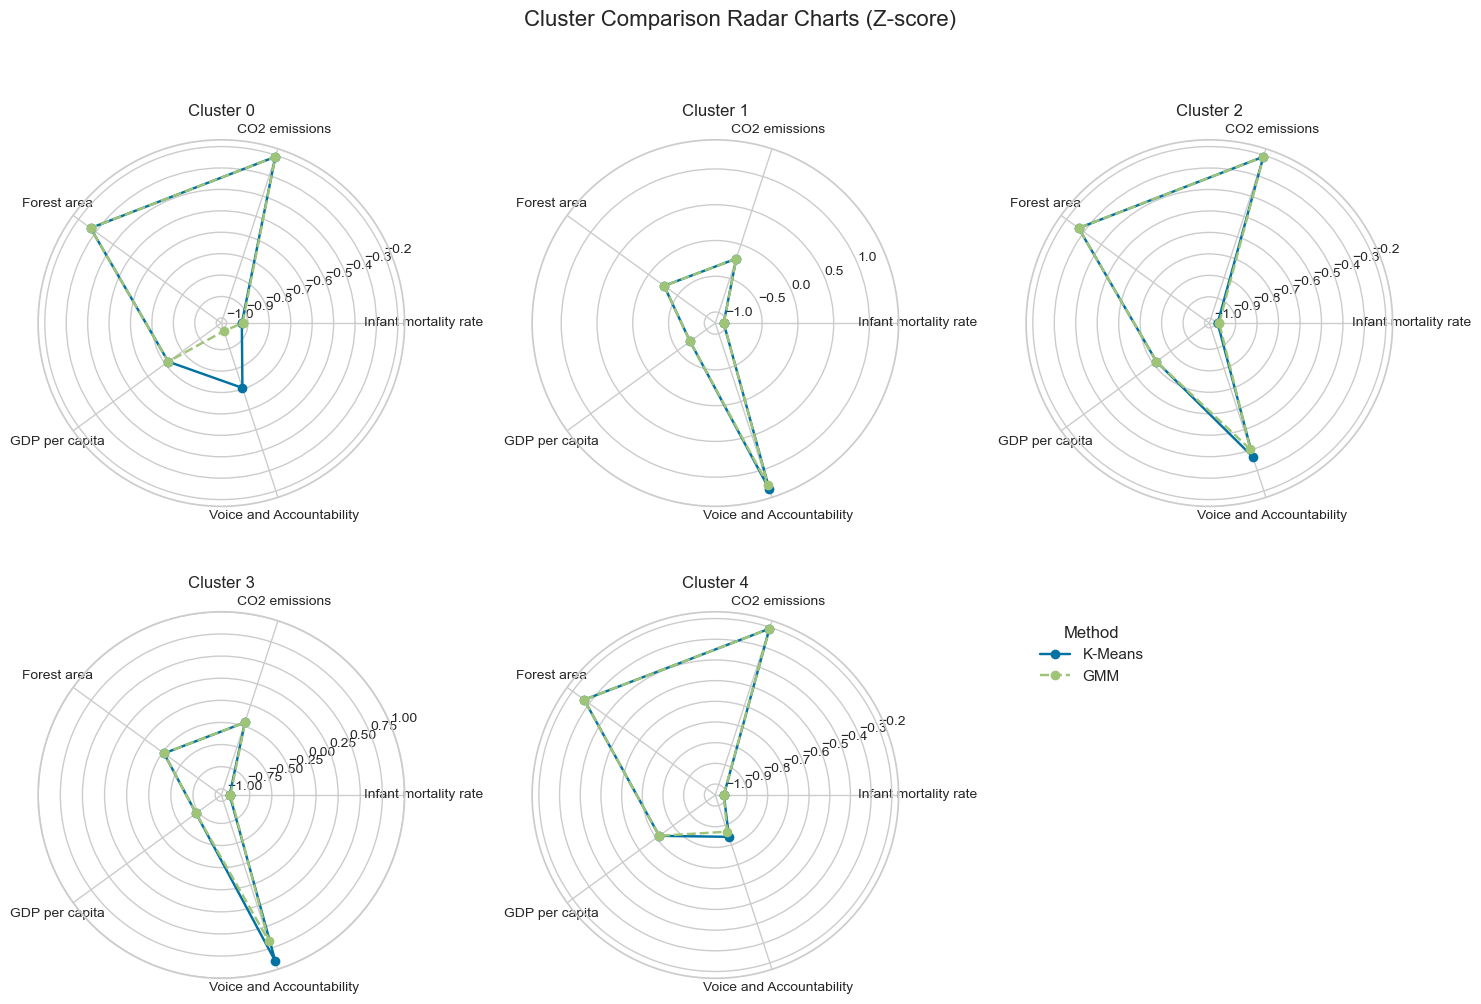

In [18]:
features = ['Infant mortality rate','CO2 emissions','Forest area','GDP per capita','Voice and Accountability']

# Z-score calculation
global_mean = develop_clean[features].mean()
global_std = develop_clean[features].std()

km_z = (develop_km.groupby('Cluster')[features].mean() - global_mean) / global_std
gmm_z = (develop_gmm.groupby('Cluster')[features].mean() - global_mean) / global_std

num_features = len(features)
angles = [n / float(num_features) * 2 * pi for n in range(num_features)]
angles += angles[:1]  # close the loop

# 2*3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw=dict(polar=True))
axes = axes.flatten()

for cluster in range(5):
    ax = axes[cluster]
    
    # K-Means
    values_km = km_z.loc[cluster].tolist()
    values_km += values_km[:1]
    ax.plot(angles, values_km, marker='o', linestyle='-', label='K-Means')
    
    # GMM
    values_gmm = gmm_z.loc[cluster].tolist()
    values_gmm += values_gmm[:1]
    ax.plot(angles, values_gmm, marker='o', linestyle='--', label='GMM')
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    ax.set_title(f'Cluster {cluster}')

# legend setting
axes[-1].axis('off')  # hide
handles, labels = axes[0].get_legend_handles_labels()
axes[-1].legend(handles, labels, loc='upper left', title='Method', fontsize=11, frameon=False)

# set title
fig.suptitle('Cluster Comparison Radar Charts (Z-score)', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()